## Import des librairies et des fichiers

In [1]:
import requests
import pandas as pd
import json
import numpy as np
import plotly.graph_objects as gp
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from datetime import date,timedelta


In [2]:
# Import des résultats du ratissage de Babelio

df=pd.read_json("books-sample1.json",lines=True)

In [18]:
# Import du lexique des émotions et transformation en dictionnaire

emotions=pd.read_csv("lexique_emotions.csv",delimiter=";")
dict_emotions={m:s for m,s in zip(emotions["mot"].tolist(),emotions["sentiment"].tolist())}
dict_emotions

{'rage': 'colère',
 'fureur': 'colère',
 'insupportable': 'colère',
 'exaspération': 'colère',
 'exaspérant': 'colère',
 'exaspérante': 'colère',
 'agacement': 'colère',
 'agaçant': 'colère',
 'agaçante': 'colère',
 'contrariété': 'colère',
 'courroux': 'colère',
 'âpre': 'colère',
 'férocité': 'colère',
 'dureté': 'colère',
 'brutalité': 'colère',
 'brutal': 'colère',
 'brutale': 'colère',
 'froideur': 'colère',
 'sauvage': 'colère',
 'vengée': 'colère',
 'vengé': 'colère',
 'cruel': 'colère',
 'cruelle': 'colère',
 'cruauté': 'colère',
 'vengeance': 'colère',
 'ressentiment': 'colère',
 'rancœur': 'colère',
 'grogne': 'colère',
 'hargne': 'colère',
 'irritation': 'colère',
 'irritée': 'colère',
 'irrité': 'colère',
 'massacre': 'colère',
 'fâché': 'colère',
 'furieux': 'colère',
 'carnage': 'colère',
 'furibond': 'colère',
 'révoltant': 'colère',
 'révoltante': 'colère',
 'révolte': 'colère',
 'révolté': 'colère',
 'révoltée': 'colère',
 'outragé': 'colère',
 'offensée': 'colère',
 '

In [97]:
# Import et chargement de la librairie Spacy en français

import spacy
nlp = spacy.load("fr_core_news_sm")

c:\Users\antoi\anaconda3\lib\site-packages\spacy\util.py:837: UserWarning: [W095] Model 'fr_core_news_sm' (3.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


## Prétraitement de texte

In [5]:
# Retrait des retour-chariot dans les commentaires

df["commentaire"]=df["commentaire"].apply(lambda x : x.replace("\n","").replace("\t",""))

In [6]:
#df["commentaire"]=df["commentaire"].apply(lambda x : " ".join(x))

In [7]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [8]:
# Retrait des caractères spéciaux et mise en minuscules des mots

df['com_process'] = df['commentaire'].str.replace(r"[!\"#$%&()*+,-./:;•♪♫<=>«»?@[\\\]^_`{|}~]+", " ")
df['com_process'] = df['com_process'].fillna('').apply(lambda x: x.lower())
df.head(5)

C:\Users\antoi\AppData\Local\Temp\ipykernel_9448\3564798599.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['com_process'] = df['commentaire'].str.replace(r"[!\"#$%&()*+,-./:;•♪♫<=>«»?@[\\\]^_`{|}~]+", " ")


,book_id,book_nb_comm,title,name,surname,tags,img_url,comm_id,user_id,note,date,appreciations,commentaire,com_process
0,905033,137,"Le gang de la clef à molette (Ne meurs pas, ô ...",Edward,Abbey,"roman,romans policiers et polars,thriller,colo...",/couv/CVT_cvt_Le-gang-de-la-clef-a-molette_345...,2080694,706958,4.0,30 novembre 2019,85,Roadtrip désertique dans l'Ouest Américain en ...,roadtrip désertique dans l'ouest américain en ...
1,905033,137,"Le gang de la clef à molette (Ne meurs pas, ô ...",Edward,Abbey,"roman,romans policiers et polars,thriller,colo...",/couv/CVT_cvt_Le-gang-de-la-clef-a-molette_345...,1271915,319761,5.0,03 mars 2017,68,"De temps en temps, j'aime bien revenir vers l'...",de temps en temps j'aime bien revenir vers l'...
2,905033,137,"Le gang de la clef à molette (Ne meurs pas, ô ...",Edward,Abbey,"roman,romans policiers et polars,thriller,colo...",/couv/CVT_cvt_Le-gang-de-la-clef-a-molette_345...,1093854,128814,5.0,27 juin 2016,67,"Depuis peu j'ai découvert grâce à "" Cardabelle...",depuis peu j'ai découvert grâce à cardabelle...
3,905033,137,"Le gang de la clef à molette (Ne meurs pas, ô ...",Edward,Abbey,"roman,romans policiers et polars,thriller,colo...",/couv/CVT_cvt_Le-gang-de-la-clef-a-molette_345...,2711430,227017,4.5,22 juillet 2021,64,"Ils sont quatre. Une blonde , jeunette, venue ...",ils sont quatre une blonde jeunette venue ...
4,905033,137,"Le gang de la clef à molette (Ne meurs pas, ô ...",Edward,Abbey,"roman,romans policiers et polars,thriller,colo...",/couv/CVT_cvt_Le-gang-de-la-clef-a-molette_345...,2685514,138438,4.5,26 juin 2021,64,Avez-vous entendu cette info effrayante ? « La...,avez vous entendu cette info effrayante la...


In [9]:
#df['commentaire'].str.replace('[^A-zA-ù0-9]', ' ', regex=True)

In [10]:
df["note"]=df["note"].replace("",np.nan)

In [11]:
df["note"]=df["note"].astype("float")

In [12]:
df["note_p"]=df["note"]/5

In [96]:
# Import des mots-vides de la langue française

from spacy.lang.fr.stop_words import STOP_WORDS as mots_vides

In [99]:
"se" in mots_vides

True

In [14]:
# Ajout de certains mots récurrents aux mots-vides

nlp.Defaults.stop_words.add("d")
nlp.Defaults.stop_words.add("l")
nlp.Defaults.stop_words.add("n")
nlp.Defaults.stop_words.add("livre")
nlp.Defaults.stop_words.add("roman")
nlp.Defaults.stop_words.add("auteur")
nlp.Defaults.stop_words.add("personnage")
nlp.Defaults.stop_words.add("personnages")

In [15]:
# Ajout des noms et prénoms des auteurs et autrices aux mots-vides

for e in df["name"].unique():
    nlp.Defaults.stop_words.add(str.lower(e))

for e in df["surname"].unique():
    nlp.Defaults.stop_words.add(str.lower(e))

In [16]:
# Tokenization des commentaires en prétraitement

tokenized_doc = df['com_process'].fillna('').apply(lambda x: nlp(x))



KeyboardInterrupt: 

In [ ]:
# Retrait effectif des mots-vides

df["tokenized"] = tokenized_doc.apply(lambda x: [token for token in x if token.text not in mots_vides])

In [100]:
# Finalisation du prétraitement de texte des commentaires

df["com_final"] = df["tokenized"].apply(lambda x: ' '.join(str(v) for v in x))

In [ ]:
# Isolement des mots liés aux sentiments répertoriés dans le dictionnaire des émotions

df["filtre_sentiments"] = tokenized_doc.apply(lambda x: [token for token in x if token.text not in mots_vides and token.text in dict_emotions.keys()])


In [ ]:
# Identification des sentiments correspondants

df["sentimentest"] = tokenized_doc.apply(lambda x: [dict_emotions[token.text] for token in x if token.text not in mots_vides and token.text in dict_emotions.keys()])


In [ ]:
# Finalisation du prétraitement focalisé sur les sentiments

df["sentiments_final"] = df["sentimentest"].apply(lambda x: ' '.join(str(v) for v in x))

In [ ]:
#ds["filtre_sentiments"] = tokenized_doc.apply(lambda x: [token for token in x if token.text not in mots_vides and token.text in dict_emotions.keys()])

In [ ]:
df["tokenized_doc"]=tokenized_doc

In [ ]:
# Enregistrement du dataframe au format csv pour utilisations futures

df.to_csv("df_nlp.csv",encoding="utf-8")

In [ ]:
dtest=pd.read_csv("df_nlp.csv")
dtest.head(2)

,Unnamed: 0,book_id,book_nb_comm,title,name,surname,tags,img_url,comm_id,user_id,...,appreciations,commentaire,note_p,com_process,tokenized,filtre_sentiments,sentimentest,sentiments_final,com_final,tokenized_doc
0,0,905033,137,"Le gang de la clef à molette (Ne meurs pas, ô ...",Edward,Abbey,"roman,romans policiers et polars,thriller,colo...",/couv/CVT_cvt_Le-gang-de-la-clef-a-molette_345...,2080694,706958,...,85,Roadtrip désertique dans l'Ouest Américain en ...,0.8,roadtrip désertique dans l'ouest américain en ...,"[roadtrip, désertique, ouest, américain, compa...","[furieux, plaisir]","['colère', 'joie']",colère joie,roadtrip désertique dans l' ouest américain en...,roadtrip désertique dans l'ouest américain en ...
1,1,905033,137,"Le gang de la clef à molette (Ne meurs pas, ô ...",Edward,Abbey,"roman,romans policiers et polars,thriller,colo...",/couv/CVT_cvt_Le-gang-de-la-clef-a-molette_345...,1271915,319761,...,68,"De temps en temps, j'aime bien revenir vers l'...",1.0,de temps en temps j'aime bien revenir vers l'...,"[temps, temps, , aime, bien, revenir, oeuvre,...","[réflexion, intelligent, bonheur, plaisir, rir...","['réflexion', 'réflexion', 'joie', 'joie', 'jo...",réflexion réflexion joie joie joie peur joie,de temps en temps j' aime bien revenir vers ...,de temps en temps j'aime bien revenir vers l'...


In [ ]:
def return_POS(sentence):
    # Tokeniser la phrase
    doc = nlp(sentence)
    # Retourner les étiquettes de chaque token
    return [(X, X.pos_) for X in doc]

In [ ]:
dict={pos[0].text:pos[1] for pos in return_POS(df.loc[0,"com_final"])}

In [ ]:
adjectifs=[m for m in dict if dict[m]=="ADJ"]

## Analyse exploratoire

In [ ]:
import matplotlib.pyplot as plt
import wordcloud

In [ ]:
doc=nlp(df.loc[0,"com_final"])

In [ ]:
random_title = np.random.choice(df["title"].unique())
random_title

'Le gone du Chaâba'

In [ ]:
ndm = nlp(" ".join(df[df["title"]==random_title].loc[:,"sentiments_final"].tolist()))

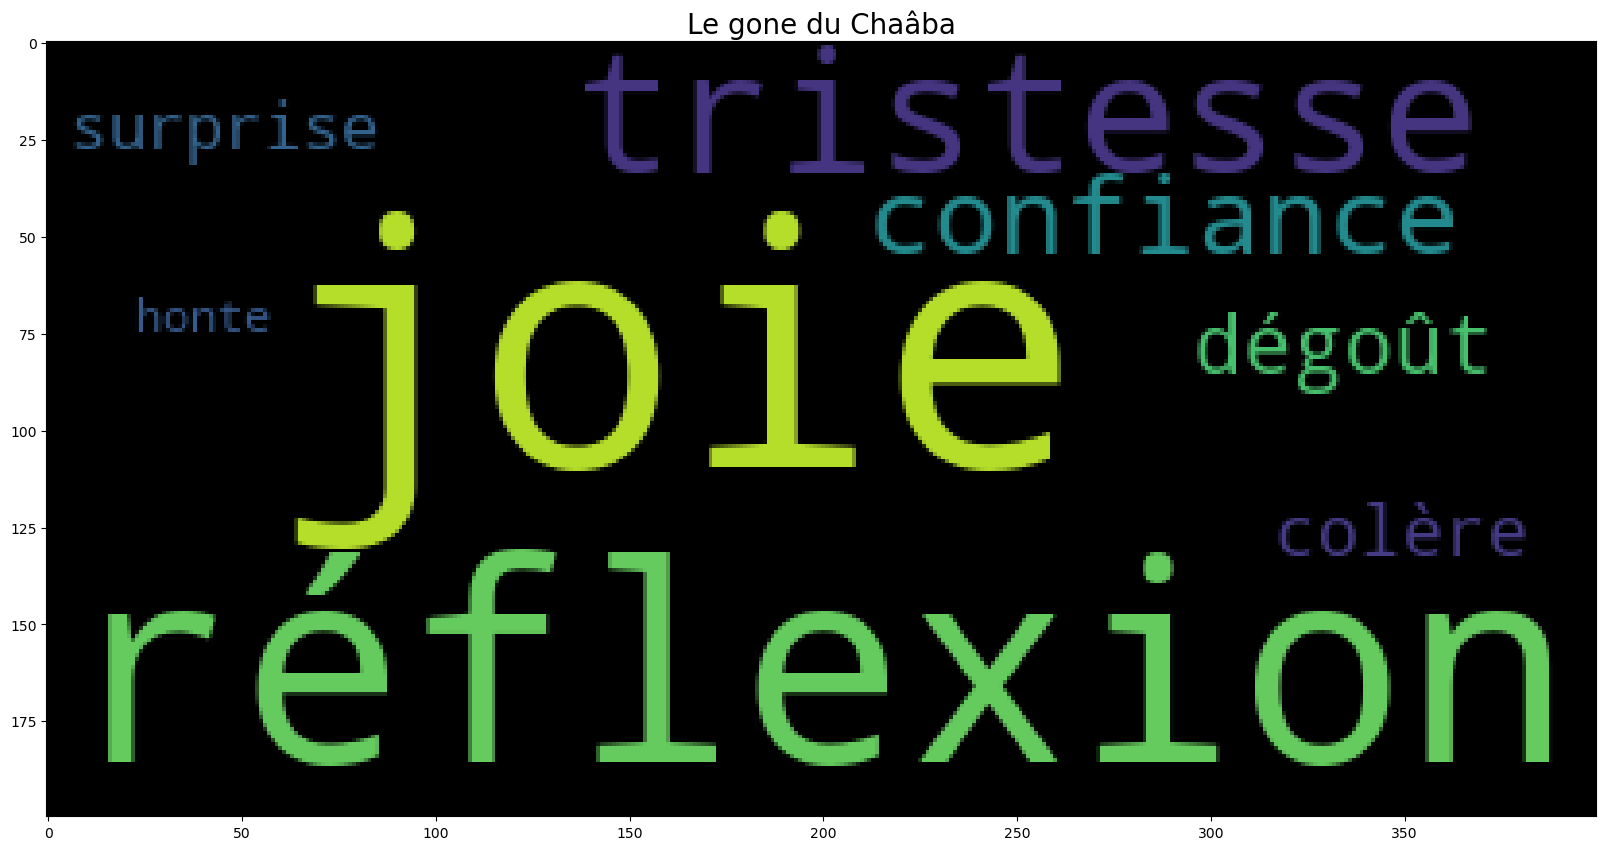

In [ ]:
wd = wordcloud.WordCloud()
cloud = wd.generate(ndm.text)

# Show word cloud with matplotlib 
plt.figure(figsize=(20,20))
plt.imshow(cloud)
plt.title(random_title,fontsize=20)


# Remove trailing logs 
plt.show()

## Création des vecteurs de sentiments

In [2]:
ds2=pd.read_csv("df_nlp_paquet2.csv")
ds3=pd.read_csv("df_nlp_paquet3.csv")
ds4=pd.read_csv("df_nlp_paquet4.csv")
df=pd.concat([ds2,ds3,ds4])

In [27]:
# Import de TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [28]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, 
    min_df=2, 
    max_features=1000, 
    #stop_words='english'
)

In [7]:
df.head()

,Unnamed: 0,book_id,book_nb_comm,title,name,surname,tags,img_url,comm_id,user_id,...,date,appreciations,commentaire,com_process,tokenized,com_final,filtre_sentiments,sentimentest,sentiments_final,tokenized_doc
0,62124,1379642,87,Voyage au bout de l'enfance,Rachid,Benzine,"roman,poésie,jeunesse,daesh,enfance,mort,enfan...",https://m.media-amazon.com/images/I/51yuE4ZBfl...,2928765,623574,...,12 février 2022,137,Pas besoin d'un grand livre pour nous faire vo...,pas besoin d'un grand livre pour nous faire vo...,"[besoin, grand, faire, voir, horreur, , déchi...",pas besoin d' un grand livre pour nous faire v...,"[horreur, paradis, paradis, poignant, horreur,...","['dégoût', 'joie', 'joie', 'tristesse', 'dégoû...",dégoût joie joie tristesse dégoût joie dégoût ...,pas besoin d'un grand livre pour nous faire vo...
1,62125,1379642,87,Voyage au bout de l'enfance,Rachid,Benzine,"roman,poésie,jeunesse,daesh,enfance,mort,enfan...",https://m.media-amazon.com/images/I/51yuE4ZBfl...,2906402,23830,...,25 janvier 2022,129,"Élève de CE2, Fabien est un petit garçon heure...",élève de ce2 fabien est un petit garçon heure...,"[élève, ce2, , petit, garçon, heureux, banlie...",élève de ce2 fabien est un petit garçon heur...,"[horreur, violence, misère, prenant]","['dégoût', 'colère', 'tristesse', 'tristesse']",dégoût colère tristesse tristesse,élève de ce2 fabien est un petit garçon heure...
2,62126,1379642,87,Voyage au bout de l'enfance,Rachid,Benzine,"roman,poésie,jeunesse,daesh,enfance,mort,enfan...",https://m.media-amazon.com/images/I/51yuE4ZBfl...,3053321,751192,...,30 mai 2022,81,Fabien a dix ans quand le départ subit de ses ...,fabien a dix ans quand le départ subit de ses ...,"[ans, départ, subit, parents, syrie, arrache, ...",fabien a dix ans quand le départ subit de ses ...,"[paradis, atrocité, terreur, violence, terreur...","['joie', 'dégoût', 'peur', 'colère', 'peur', '...",joie dégoût peur colère peur peur colère colère,fabien a dix ans quand le départ subit de ses ...
3,62127,1379642,87,Voyage au bout de l'enfance,Rachid,Benzine,"roman,poésie,jeunesse,daesh,enfance,mort,enfan...",https://m.media-amazon.com/images/I/51yuE4ZBfl...,2925538,29342,...,10 février 2022,77,"On ouvre ce livre, on prend connaissance de la...",on ouvre ce livre on prend connaissance de la...,"[ouvre, , prend, connaissance, situation, pet...",on ouvre ce livre on prend connaissance de l...,"[horreur, souffrance, paradis, bonheur, amère]","['dégoût', 'dégoût', 'joie', 'joie', 'tristesse']",dégoût dégoût joie joie tristesse,on ouvre ce livre on prend connaissance de la...
4,62128,1379642,87,Voyage au bout de l'enfance,Rachid,Benzine,"roman,poésie,jeunesse,daesh,enfance,mort,enfan...",https://m.media-amazon.com/images/I/51yuE4ZBfl...,2977853,1127438,...,24 mars 2022,66,"Fabien, un petit garçon de 8 ans qui habite Sa...",fabien un petit garçon de 8 ans qui habite sa...,"[ , petit, garçon, 8, ans, habite, sarcelles, ...",fabien un petit garçon de 8 ans qui habite s...,"[paradis, profondeur, déçue, intéressant]","['joie', 'réflexion', 'tristesse', 'réflexion']",joie réflexion tristesse réflexion,fabien un petit garçon de 8 ans qui habite sa...


In [31]:
# Création du dataframe df_vect pour générer les vecteurs de sentiments à partir de leurs tf-idf par livre

liste_emotions=["joie","confiance","surprise","peur","tristesse","colère","honte","réflexion"]

dict_vect = {}

for bookid,title in zip(df["book_id"].unique(),df["title"].unique()):
    tfidf = tfidf_vectorizer.fit_transform(df[df["title"] == title]["sentiments_final"].values.astype("U"))
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    df_tfidf = pd.DataFrame(tfidf.toarray(), columns=[x for x in tfidf_vectorizer.get_feature_names_out()]).reset_index()
    df_def = df_tfidf.describe().T.iloc[1:,:]["mean"]
    df_to_vec = pd.DataFrame({"book_id":[bookid]*len(liste_emotions),
                              "title":[title]*len(liste_emotions),
                              "emotion":liste_emotions,
                              "valeur":[df_def.loc[em] if em in df_def.index else 0 for em in liste_emotions]
                             })

    df_to_vec["poids"] = df_to_vec["valeur"]/df_to_vec["valeur"].sum()

    dict_vect[title] = df_to_vec

df_vect = pd.concat(dict_vect.values())

df_vect



,book_id,title,emotion,valeur,poids
0,1379642,Voyage au bout de l'enfance,joie,0.246306,0.196760
1,1379642,Voyage au bout de l'enfance,confiance,0.091769,0.073309
2,1379642,Voyage au bout de l'enfance,surprise,0.145639,0.116343
3,1379642,Voyage au bout de l'enfance,peur,0.123981,0.099041
4,1379642,Voyage au bout de l'enfance,tristesse,0.282356,0.225558
...,...,...,...,...,...
3,1379634,Pour en finir avec Dieu,peur,0.000000,0.000000
4,1379634,Pour en finir avec Dieu,tristesse,0.000000,0.000000
5,1379634,Pour en finir avec Dieu,colère,0.052490,0.062066
6,1379634,Pour en finir avec Dieu,honte,0.000000,0.000000


In [32]:
# À partir de df_vect, création du dataframe final des vecteurs de sentiments par livre

dft = pd.pivot_table(df_vect,index=["book_id","title"],columns=["emotion"],values=["poids"])
dft.columns = dft.columns.droplevel(0)
dft=dft.reset_index()
dft.columns = dft.columns[0:2].tolist()+["sen_"+name for name in dft.columns[2:len(dft.columns)]]
dft

,book_id,title,sen_colère,sen_confiance,sen_honte,sen_joie,sen_peur,sen_réflexion,sen_surprise,sen_tristesse
0,1511,"La neuvième maison, tome 1",0.133322,0.084686,0.042228,0.196169,0.045325,0.107057,0.231678,0.159534
1,1526,Amok ou Le fou de Malaisie,0.163079,0.097209,0.074223,0.098564,0.112604,0.104324,0.192106,0.157889
2,1576,"Le Photographe, tome 2",0.099799,0.045419,0.000000,0.183093,0.079083,0.140925,0.176220,0.275461
3,1579,T'embrasser sous la neige,0.037088,0.253690,0.014968,0.220779,0.066128,0.062361,0.104308,0.240678
4,1594,A la grâce des hommes,0.136069,0.180343,0.000000,0.152555,0.087607,0.102654,0.083329,0.257444
...,...,...,...,...,...,...,...,...,...,...
1494,1434407,La passion selon Juette,0.146370,0.189510,0.031835,0.151226,0.047422,0.165494,0.134117,0.134027
1495,1439561,Verte,0.048147,0.090697,0.000000,0.330369,0.078597,0.206776,0.149983,0.095430
1496,1448979,Rouge-Gorge,0.031821,0.125111,0.074603,0.234219,0.097185,0.199430,0.080980,0.156651
1497,1453510,"Moriarty, tome 2",0.133854,0.057507,0.045551,0.176357,0.101162,0.327204,0.077776,0.080589


In [ ]:
# Chargement dans un fichier json

dft.to_json("vecteurs_sentiments_2.json",lines=True,orient="records")

## Similarité cosinus

In [34]:
from scipy import spatial

In [35]:
# Essai de calcul de similarité cosinus entre deux vecteurs de sentiments

random_title = np.random.choice(df_vect["title"].unique())
print(random_title)
random_title2 = np.random.choice(df_vect["title"].unique())
print(random_title2)
v1 = df_vect[df_vect["title"]==random_title]["poids"].tolist()
v2 = df_vect[df_vect["title"]==random_title2]["poids"].tolist()
print(v1)
print(v2)
1 - spatial.distance.cosine(v1, v2)

Off-campus, tome 3 : The score
Les sept soeurs, tome 6 : La soeur du soleil
[0.32377631868646994, 0.15405498398337591, 0.14769773915948503, 0.0426675934455292, 0.15145887462750857, 0.030229711266828586, 0.0234121154202638, 0.12670266341053874]
[0.35712905232101017, 0.14398566190019063, 0.10949906360955465, 0.0, 0.2268747483213378, 0.025647438022566478, 0.0, 0.13686403582534032]


0.9784289249430237

In [36]:
# Génération d'un radar de sentiment sur le premier livre pris au hasard pour la similarité cosinus

fig = px.line_polar(df_vect[df_vect["title"]=="random_title"],r=df_vect[df_vect["title"]==random_title]["poids"],theta=df_vect[df_vect["title"]==random_title]["emotion"],
                    line_close=True, range_r=[0,max(df_vect[df_vect["title"]==random_title]["poids"])+0.1],title=random_title)
fig.show()

c:\Users\antoi\anaconda3\lib\site-packages\plotly\express\_core.py:271: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trace_data = trace_data.append(trace_data.iloc[0])


## Distances Jaccard

In [3]:
# Initiation d'un dataframe vide sous forme de matrice carré 1500 x 1500 pour le présent exemple où 1500 est le nombre de livres

mtx2 = pd.DataFrame(index=df["book_id"].unique(),columns=df["book_id"].unique())

In [ ]:
# Création de la fonction jaccatd_similarity pour la calculer la distance Jaccard entre les commentaires de deux livres donnés

def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return float(intersection) / union

In [9]:
# Remplissage du dataframe de manière à ce qu'il représente une matrice carrée triangulaire inférieure pour éviter les doublons dans les combinaisons et gagner du temps de calcul

for i,id in enumerate(df["book_id"].unique()):

    for idd in df["book_id"].unique()[i:len(df["book_id"].unique())+1]:

        #v1 = df_vect[df_vect["book_id"]==id]["poids"].tolist()
        #v2 = df_vect[df_vect["book_id"]==idd]["poids"].tolist()

        #simcos = 1 - spatial.distance.cosine(v1, v2)

        w1=" ".join(list(set(" ".join([x for x in df[df["book_id"]==id]["com_final"].tolist() if isinstance(x, str)]).split(" "))))
        w2=" ".join(list(set(" ".join([x for x in df[df["book_id"]==idd]["com_final"].tolist() if isinstance(x, str)]).split(" "))))

        jacsim = jaccard_similarity(w1,w2)

        #coef = simcos * jacsim

        mtx2.loc[idd,id]=jacsim

    print(i,"done")

0 done
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
51 done
52 done
53 done
54 done
55 done
56 done
57 done
58 done
59 done
60 done
61 done
62 done
63 done
64 done
65 done
66 done
67 done
68 done
69 done
70 done
71 done
72 done
73 done
74 done
75 done
76 done
77 done
78 done
79 done
80 done
81 done
82 done
83 done
84 done
85 done
86 done
87 done
88 done
89 done
90 done
91 done
92 done
93 done
94 done
95 done
96 done
97 done
98 done
99 done
100 done
101 done
102 done
103 done
104 done
105 done
106 done
107 done
108 done
109 done
110 done
111 done
112 done
113 done
114 done
115 done
116 done
117 done
118 done
119 done
120 done
121 done
122 done
123

In [37]:
# Affichage de la matrice

mtx2

,1379642,466996,123961,338279,1300939,1079315,832220,56385,676627,698482,...,20799,812075,895066,22977,40020,1000176,794245,225627,1379634,81141
1379642,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
466996,0.791045,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123961,0.742857,0.928571,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
338279,0.690141,0.859649,0.862069,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1300939,0.728571,0.877193,0.847458,0.844828,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000176,0.728571,0.910714,0.87931,0.877193,0.862069,0.731343,0.883333,0.864407,0.830508,0.877193,...,0.833333,0.881356,0.85,0.862069,0.866667,1.0,NaN,NaN,NaN,NaN
794245,0.764706,0.962963,0.928571,0.859649,0.844828,0.796875,0.836066,0.912281,0.910714,0.962963,...,0.87931,0.896552,0.896552,0.910714,0.85,0.877193,1.0,NaN,NaN,NaN
225627,0.7,0.875,0.844828,0.875,0.766667,0.753846,0.819672,0.894737,0.892857,0.875,...,0.894737,0.816667,0.912281,0.859649,0.803279,0.827586,0.875,1.0,NaN,NaN
1379634,0.732394,0.87931,0.85,0.786885,0.803279,0.735294,0.769231,0.836066,0.803279,0.87931,...,0.836066,0.852459,0.852459,0.864407,0.809524,0.803279,0.87931,0.8,1.0,NaN


In [10]:
# Enregistrement de la matrice des distances Jaccard au format csv

mtx2.to_csv("jacsim.csv")

In [ ]:
random_title = np.random.choice(df_vect["title"].unique())
print(random_title)
random_title2 = np.random.choice(df_vect["title"].unique())
print(random_title2)
v1 = df_vect[df_vect["title"]==random_title]["poids"].tolist()
v2 = df_vect[df_vect["title"]==random_title2]["poids"].tolist()
print(v1)
print(v2)
1 - spatial.distance.cosine(v1, v2)

In [81]:
x1=df_vect[df_vect["title"]==random_title].loc[0,"book_id"]
x2=df_vect[df_vect["title"]==random_title2].loc[0,"book_id"]

In [82]:
def get_jaccard(x1,x2):

    if mtx2.loc[x1,x2]==np.nan:
        return mtx2.loc[x2,x1]
    else:
        return mtx2.loc[x1,x2]

In [83]:
get_jaccard(x1,x2)

0.7352941176470589

In [ ]:
random_title = np.random.choice(df_vect["title"].unique())
print(random_title)
random_title2 = np.random.choice(df_vect["title"].unique())
print(random_title2)
v1 = df_vect[df_vect["title"]==random_title]["poids"].tolist()
v2 = df_vect[df_vect["title"]==random_title2]["poids"].tolist()
print(v1)
print(v2)
print()
print(1 - spatial.distance.cosine(v1, v2))

print()

a=" ".join([x for x in df[df["title"]==random_title]["com_final"].tolist() if isinstance(x, str)])
b=" ".join([x for x in df[df["title"]==random_title2]["com_final"].tolist() if isinstance(x, str)])
print(jaccard_similarity(a,b))